In [87]:
import pandas as pd
# import csv to visualise data
df = pd.read_csv('/Users/stephen/Documents/college/machine-learning/assignment-3/data/owls-csv.csv')

Populating the interactive namespace from numpy and matplotlib


/Users/stephen/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


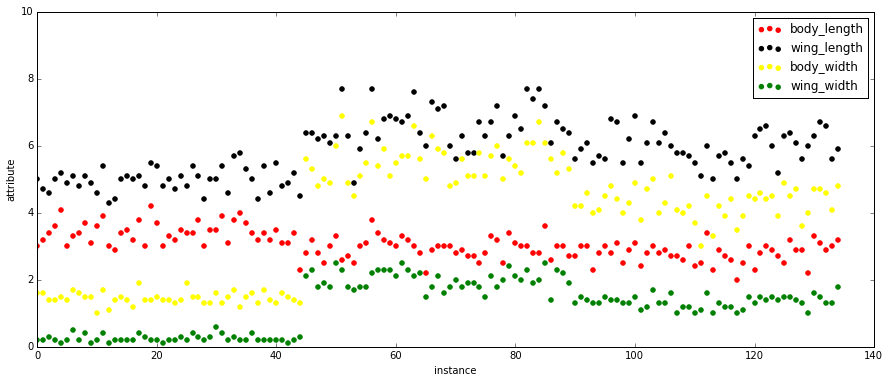

In [88]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
%pylab inline

# setup figure
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
# plot the data 
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax1.scatter(np.arange(135), df.body_length, color='red', cmap=cm_bright, label='body_length') 
ax1.scatter(np.arange(135), df.wing_length, color='black', cmap=cm_bright, label='wing_length') 
ax1.scatter(np.arange(135), df.body_width, color='yellow', cmap=cm_bright, label='body_width') 
ax1.scatter(np.arange(135), df.wing_width, color='green', cmap=cm_bright, label='wing_width') 
ax1.set_xlim(0, 140)
ax1.set_ylim(0, 10)
ax1.set_xlabel('instance')
ax1.set_ylabel('attribute')
ax1.legend(loc='upper right')

In [89]:
import sys
import numpy
import csv
numpy.seterr(all='ignore')

# softmax - like logisitc regression function, use the logit function 
#           to convert the infinite scale of inputs to a 
# @params {Object} data - json object
def softmax(x):
    e = numpy.exp(x - numpy.max(x))  # prevent overflow
    if e.ndim == 1:
        return e / numpy.sum(e, axis=0)
    else:  
        return e / numpy.array([numpy.sum(e, axis=1)]).T  # ndim = 4
# 
def file_reader(file_name):
    inputs = [];
    i = 0;
    with open(file_name, 'r') as csvfile:
        file = csv.reader(csvfile, delimiter='\n')
        for row in file:
            split_row = row[0].split(',')
            floats = [float(x) for x in split_row]
            inputs.append(floats)
    # return the input array
    return inputs;

class LogisticRegression(object):
    def __init__(self, input, label, n_in, n_out):
        self.x = input
        self.y = label
        self.W = numpy.zeros((n_in, n_out))  # initialize W 0
        self.b = numpy.zeros(n_out)          # initialize bias 0

        # self.params = [self.W, self.b]

    def train(self, lr=0.1, input=None, L2_reg=0.00):
        if input is not None:
            self.x = input

        # p_y_given_x = sigmoid(numpy.dot(self.x, self.W) + self.b)
        p_y_given_x = softmax(numpy.dot(self.x, self.W) + self.b)
        d_y = self.y - p_y_given_x
        
        self.W += lr * numpy.dot(self.x.T, d_y) - lr * L2_reg * self.W
        self.b += lr * numpy.mean(d_y, axis=0)
        
        # cost = self.negative_log_likelihood()
        # return cost

    def negative_log_likelihood(self):
        # sigmoid_activation = sigmoid(numpy.dot(self.x, self.W) + self.b)
        sigmoid_activation = softmax(numpy.dot(self.x, self.W) + self.b)

        cross_entropy = - numpy.mean(
            numpy.sum(self.y * numpy.log(sigmoid_activation) +
            (1 - self.y) * numpy.log(1 - sigmoid_activation),
                      axis=1))

        return cross_entropy


    def predict(self, x):
        return softmax(numpy.dot(x, self.W) + self.b)


def test_algorithm(learning_rate=0.01, n_epochs=200):
    # training data
    x = numpy.array(
            file_reader('/Users/stephen/Documents/college/machine-learning/assignment-3/data/inputs')
        );

    y = numpy.array(
            file_reader('/Users/stephen/Documents/college/machine-learning/assignment-3/data/outputs')
        );

    # construct LogisticRegression
    classifier = LogisticRegression(input=x, label=y, n_in=4, n_out=3)

    # train
    for epoch in range(n_epochs):
        classifier.train(lr=learning_rate)
        cost = classifier.negative_log_likelihood()
        print(sys.stderr, 'Training epoch %d, cost is ' % epoch, cost)
        learning_rate *= 0.95


    # test
    x = numpy.array([3.4,6,4.5,1.6])
    print(sys.stderr, classifier.predict(x))


if __name__ == "__main__":
    test_algorithm()



<ipykernel.iostream.OutStream object at 0x103ee99e8> Training epoch 0, cost is  6.04715787085
<ipykernel.iostream.OutStream object at 0x103ee99e8> Training epoch 1, cost is  34.2556395107
<ipykernel.iostream.OutStream object at 0x103ee99e8> Training epoch 2, cost is  nan
<ipykernel.iostream.OutStream object at 0x103ee99e8> Training epoch 3, cost is  20.3382483286
<ipykernel.iostream.OutStream object at 0x103ee99e8> Training epoch 4, cost is  inf
<ipykernel.iostream.OutStream object at 0x103ee99e8> Training epoch 5, cost is  11.3995641249
<ipykernel.iostream.OutStream object at 0x103ee99e8> Training epoch 6, cost is  11.1906201162
<ipykernel.iostream.OutStream object at 0x103ee99e8> Training epoch 7, cost is  nan
<ipykernel.iostream.OutStream object at 0x103ee99e8> Training epoch 8, cost is  7.17896495583
<ipykernel.iostream.OutStream object at 0x103ee99e8> Training epoch 9, cost is  2.93593956351
<ipykernel.iostream.OutStream object at 0x103ee99e8> Training epoch 10, cost is  nan
<ipyk